**Online Retailer Data Analysis - Part 4 - Chustomer Churn**

This notebook is the fourth of nine parts in a project designed to demonstrate various data analytics and data science techniques, highlighting how they can enhance business intelligence and drive effective decision-making.

Using an example dataset from a telecommunications company called "Telco," this project will cover the following topics:


1. Calculating Metrics
2. Customer Segmentation
3. Customer Lifetime Value Prediction
4. **Churn Prediction**
5. Predicting Next Purchase Day
6. Predicting Sales
7. Market Response Models
8. Uplift Modeling
9. A/B Testing Design and Execution

Retention Rate is an indication of how good your product market fit (PMF) is. If your PMF is not satisfactory, you should see your customers churning very soon.

One of the powerful tools to improve Retention Rate (hence the PMF) is **Churn Prediction**. By using this technique, we can easily find out who is likely to churn in the given period. We achieve this by identifying the features that influence customer churn and understanding the factors that lead customers to leave our company. Once we understand the relations to churn, then we can apply models in order to predict which of the customers are likely to churn based on the discovered features AND apply some work to understand how we can improve the situation.


In this notebook we will use the following steps:

- Exploratory Data Analysis
- Feature Engineering
- Investigating how the features affect Retention by using Logistic Regression
- Building a classification model with XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['telco_churn1.csv']))

df.head()

Saving telco_churn1.csv to telco_churn1.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Exploratory Data Analysis**

We will start by checking out how our data looks and visualize how it interacts with our label (churned or not)



In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Let's convert our Churn column from string values (Yes/No), to integers

In [3]:
df.loc[df['Churn'] == 'Yes', 'Churn'] = 1
df.loc[df['Churn'] == 'No', 'Churn'] = 0

<Axes: xlabel='gender', ylabel='Churn'>

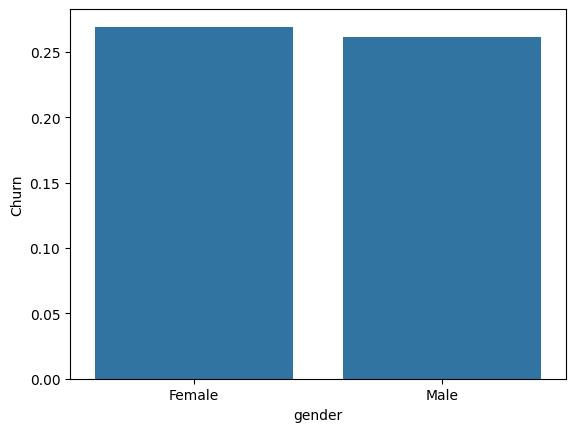

In [4]:
#Let's take a look at Gender

df_plot = df.groupby('gender').Churn.mean().reset_index()
sns.barplot(x = 'gender', y = 'Churn', data = df_plot)

In [5]:
df.groupby('gender').Churn.mean()

,Churn
gender,
Female,0.269209
Male,0.261603


The difference between male and female in accordance to churn is minimal


Repeat for all Categorical Variables:

<Axes: xlabel='InternetService', ylabel='Churn'>

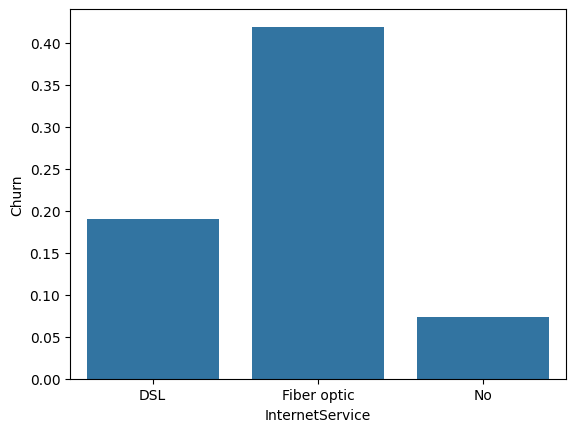

In [6]:
#Internet Service

df_plot = df.groupby('InternetService').Churn.mean().reset_index()
sns.barplot(x = 'InternetService', y = 'Churn', data = df_plot)

This chart reveals customers who have Fiber optic as Internet Service are more likely to churn. Normally we'd expect Fiber optic customers to churn less due to they use a more premium service. But this can happen due to high prices, competition, customer service, and many other reasons.

<Axes: xlabel='Contract', ylabel='Churn'>

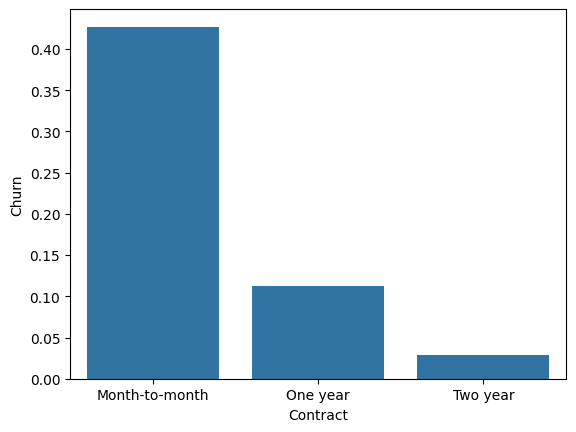

In [7]:
#Contract

df_plot = df.groupby('Contract').Churn.mean().reset_index()
sns.barplot(x = 'Contract', y = 'Churn', data = df_plot)

As expected, the shorter contract means higher churn rate.

<Axes: xlabel='TechSupport', ylabel='Churn'>

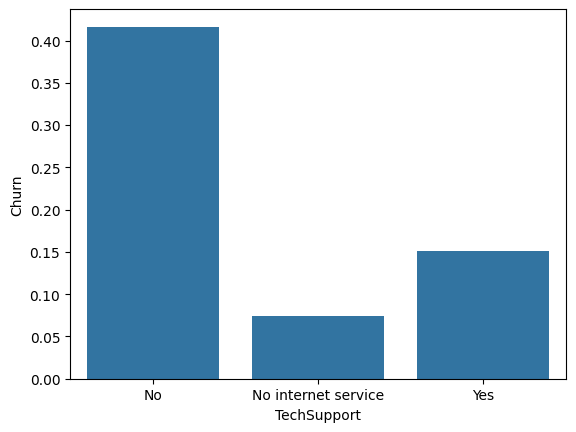

In [8]:
#Tech Support

df_plot = df.groupby('TechSupport').Churn.mean().reset_index()
sns.barplot(x = 'TechSupport', y = 'Churn', data = df_plot)

Customers don’t use Tech Support are more like to churn (~25% difference).

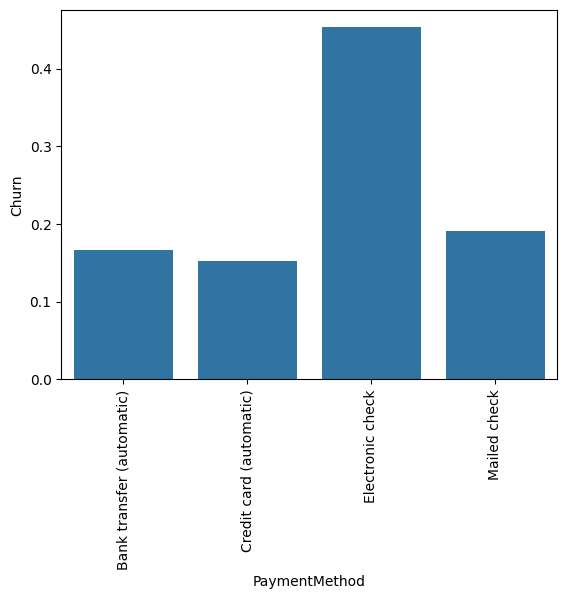

In [9]:
#Payment Method

df_plot = df.groupby('PaymentMethod').Churn.mean().reset_index()
sns.barplot(x = 'PaymentMethod', y = 'Churn', data = df_plot)

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

Automating the payment makes the customer more likely to retain in your platform (~30% difference).

Let's combine some of the remaining charts together:

<ipython-input-10-12fbdfbb2170>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-10-12fbdfbb2170>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-10-12fbdfbb2170>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-10-12fbdfbb2170>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


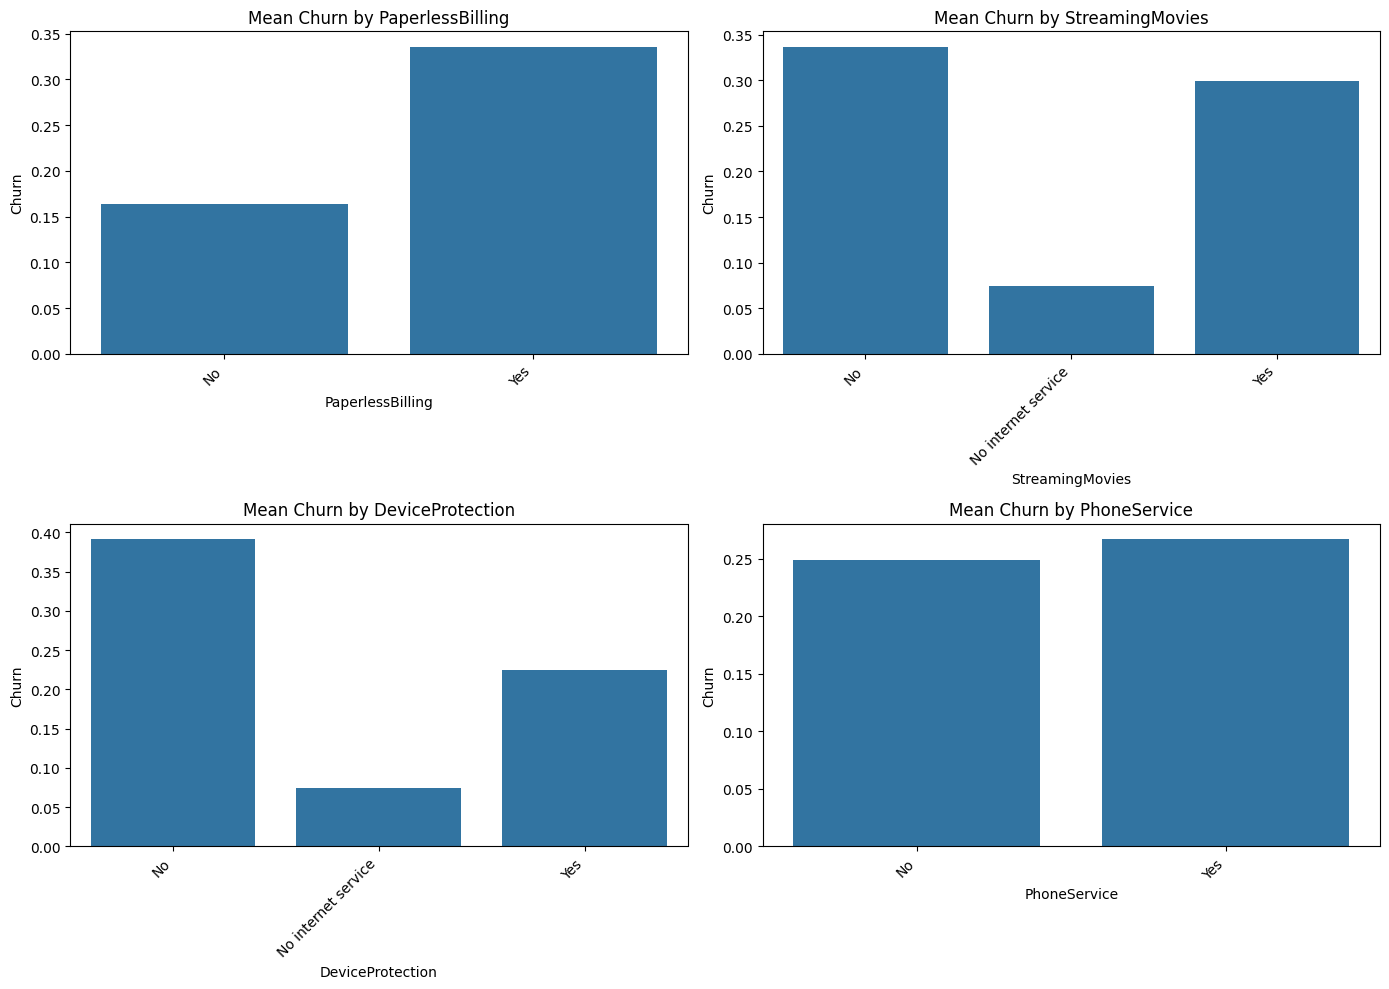

In [10]:

# List of features to plot
features = ['PaperlessBilling', 'StreamingMovies', 'DeviceProtection', 'PhoneService']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through features and plot each in its subplot
for i, feature in enumerate(features):
    # Calculate mean churn for the current feature
    df_plot = df.groupby(feature).Churn.mean().reset_index()

    # Create bar plot for the current feature
    sns.barplot(x=feature, y='Churn', data=df_plot, ax=axes[i])

    # Rotate x-axis labels for readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

    # Set plot title
    axes[i].set_title(f'Mean Churn by {feature}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


**Now Let's take a look at Numerical Features:**

**Tenure:**

In [11]:
import plotly.offline as pyoff
import plotly.graph_objs as go

df_plot = df.groupby('tenure').Churn.mean().reset_index()
plot_data = [
    go.Scatter(
        x=df_plot['tenure'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]
plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Tenure"},
        title='Tenure based Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [12]:
df.tenure.describe()

,tenure
count,7043.000000
mean,32.371149
std,24.559481
min,0.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,72.000000


In [46]:
df_plot = df.groupby('MonthlyCharges').Churn.mean().reset_index()
plot_data = [
    go.Scatter(
        x=df_plot['MonthlyCharges'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]
plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "MonthlyCharges"},
        title='MonthlyCharges Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [47]:
df_plot = df.groupby('TotalCharges').Churn.mean().reset_index()
plot_data = [
    go.Scatter(
        x=df_plot['TotalCharges'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]
plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "TotalCharges"},
        title='TotalCharges Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

**Feature Engineering**

In this section, we are going to transform our raw features to extract more information from them. Our strategy is as follows:

1- Group the numerical columns by using clustering techniques

2- Apply Label Encoder to categorical features which are binary

3- Apply get_dummies() to categorical features which have multiple values

**Numerical Columns**

As we know from the EDA section, We have three numerical columns:

- Tenure
- Monthly Charges
- Total Charges

We are going to apply the following steps to create groups:

1. Using Elbow Method to identify the appropriate number of clusters
2. Applying K-means logic to the selected column and change the naming
3. Observe the profile of clusters

In [13]:

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-14-c92c03f5d959>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-14-c92c03f5d959>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

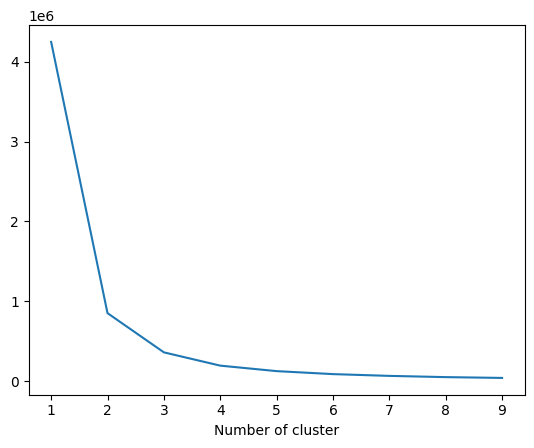

In [14]:

from sklearn.cluster import KMeans

sse={}
df_cluster = df[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['tenure']])
df['TenureCluster'] = kmeans.predict(df[['tenure']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [16]:
df = order_cluster('TenureCluster', 'tenure',df,True)

In [17]:
df.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2941.0,7.801428,6.227163,0.0,2.0,6.0,13.0,21.0
1,1929.0,34.792120,8.297679,22.0,27.0,35.0,42.0,49.0
2,2173.0,63.475380,7.172433,50.0,57.0,65.0,70.0,72.0


Here we have our clusters based on tenure, and we can see we have distinct clusters with wide ranging means. Remember, this is just a process to cluster (or group) customers based of their similarities/relations within their "tenure", this does not yet have influence on churn rate. After this process we are left with three cluster groups of customers as they relate to their tenure at the company.

Lets now apply categories to the clusters and visualize their relation to churn rate:

In [18]:
df['TenureCluster'] = df["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [19]:
df_plot = df.groupby('TenureCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TenureCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5,0.5],
        marker=dict(
        color=['green', 'blue', 'orange','red'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Tenure Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

So we can see that our cluster of "low" tenure customers are more likely to churn. This is rather intuitive given that in most business practices, customers that stay with you for longer periods of time become less likely to churn overtime. (remain loyal to brands)

Lets have a look at clusters for **Monthly Charges**:

In [20]:
df_plot = df.copy()
df_plot['MonthlyCharges'] = df_plot['MonthlyCharges'].astype(int)
df_plot = df_plot.groupby('MonthlyCharges').Churn.mean().reset_index()


plot_data = [
    go.Scatter(
        x=df_plot['MonthlyCharges'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Monthly Charges"},
        title='Monthly Charge vs Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-21-b7f2a751fe3f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-21-b7f2a751fe3f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

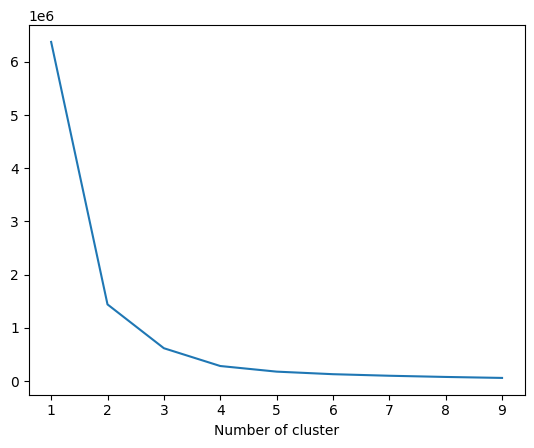

In [21]:
sse={}
df_cluster = df[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [22]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['MonthlyCharges']])
df['MonthlyChargeCluster'] = kmeans.predict(df[['MonthlyCharges']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [23]:
df_data = order_cluster('MonthlyChargeCluster', 'MonthlyCharges',df,True)

In [24]:

df_data.groupby('MonthlyChargeCluster').MonthlyCharges.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargeCluster,,,,,,,,
0,1892.0,23.384619,5.660437,18.25,19.80,20.40,25.0500,42.40
1,2239.0,61.628808,10.441432,42.60,51.80,61.55,70.7000,77.80
2,2912.0,94.054258,10.343944,77.85,85.05,93.90,101.9125,118.75


Here we have our Monthly Charge Clusters, like before let's assign them categories and inspect:


In [25]:

df_data['MonthlyChargeCluster'] = df_data["MonthlyChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [26]:
df_plot = df_data.groupby('MonthlyChargeCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['MonthlyChargeCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Monthly Charge Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Again, not very surprising, but customers with high monthly charges are likely to seek alternatives. We have a hunch that we saw this pattern earlier with fiber optic cable, as a lot of customers are likely paying a high fee for fiber optic when there are possibly cheaper alternatives.

Finally, lets have a look at **Total Charges Clusters** like we just did:

In [27]:
df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureCluster,MonthlyChargeCluster
92,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.25,,0,Low,Low
138,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.75,,0,Low,Low
425,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,19.85,,0,Low,Low
488,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.35,,0,Low,Low
566,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.00,,0,Low,Low
681,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0,Low,Low
1977,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0,Low,Mid
2116,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,No,Credit card (automatic),56.05,,0,Low,Mid
3016,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,No,Two year,No,Mailed check,73.35,,0,Low,Mid
3029,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,No,Two year,Yes,Bank transfer (automatic),61.90,,0,Low,Mid


In [28]:
len(df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()])

11

We discovered some missing data in Total Charges that doesn't bode well for our ML model, so we will remove them:

In [29]:
df_data.loc[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan

In [30]:

df_data = df_data.dropna()

In [31]:
df_data['TotalCharges'] = pd.to_numeric(df_data['TotalCharges'], errors='coerce')

In [32]:
df_plot = df_data.copy()
df_plot['TotalCharges'] = df_plot['TotalCharges'].astype(int)
df_plot = df_plot.groupby('TotalCharges').Churn.mean().reset_index()


plot_data = [
    go.Scatter(
        x=df_plot['TotalCharges'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Total Charges"},
        title='Total Charge vs Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-33-b7ef5bdbcc2c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-33-b7ef5bdbcc2c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

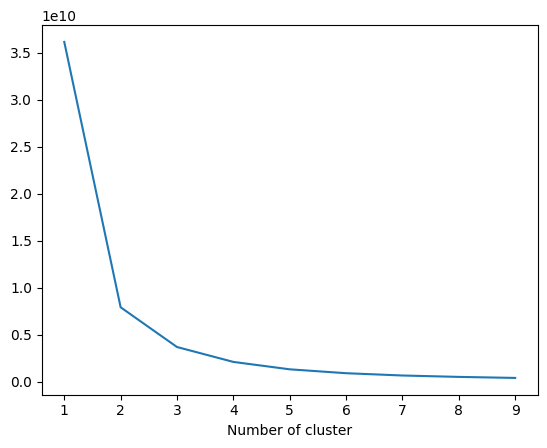

In [33]:

sse={}
df_cluster = df_data[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [34]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['TotalCharges']])
df_data['TotalChargeCluster'] = kmeans.predict(df_data[['TotalCharges']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [35]:
df_data = order_cluster('TotalChargeCluster', 'TotalCharges',df_data,True)

In [36]:

df_data.groupby('TotalChargeCluster').TotalCharges.describe()


,count,mean,std,min,25%,50%,75%,max
TotalChargeCluster,,,,,,,,
0,4162.0,686.825553,572.590106,18.8,161.5375,536.375,1142.8625,1980.30
1,1613.0,3276.079510,814.603116,1982.1,2550.9000,3213.750,3973.2000,4784.45
2,1257.0,6295.373508,1002.361555,4786.1,5471.7500,6148.450,7040.8500,8684.80


In [37]:

df_data['TotalChargeCluster'] = df_data["TotalChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [38]:
df_plot = df_data.groupby('TotalChargeCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TotalChargeCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Total Charge Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

We have to consider this information carefully, because total charges doesn't mean in one year. In this case, customers with the highest total charges have the lowest churn rates, but it is likely that they have the highest total charges because they have been with the company the longest, which we have seen leads to a better churn rate for the company. So far this is making sense.

At this point we have done quite a bit of EDA and did a great job clustering our customers so we can better identify them. Now we can move on to preparing our data for our predictions

In [39]:

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            7032 non-null   object 
 1   gender                7032 non-null   object 
 2   SeniorCitizen         7032 non-null   int64  
 3   Partner               7032 non-null   object 
 4   Dependents            7032 non-null   object 
 5   tenure                7032 non-null   int64  
 6   PhoneService          7032 non-null   object 
 7   MultipleLines         7032 non-null   object 
 8   InternetService       7032 non-null   object 
 9   OnlineSecurity        7032 non-null   object 
 10  OnlineBackup          7032 non-null   object 
 11  DeviceProtection      7032 non-null   object 
 12  TechSupport           7032 non-null   object 
 13  StreamingTV           7032 non-null   object 
 14  StreamingMovies       7032 non-null   object 
 15  Contract             

In [40]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column])
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns)

In [41]:

df_data[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

,gender,Partner,TenureCluster_High,TenureCluster_Low,TenureCluster_Mid
0,0,1,False,True,False
1,0,0,False,True,False
2,1,0,False,True,False
3,1,0,False,True,False
4,1,1,False,True,False


As you can see easily, gender & Partner columns became numerical ones, and we have three new columns for TenureCluster.

It is time to fit a **logistic regression** model and extract insights to **make better business decisions.**

**Logistic Regression**

In [42]:
all_columns = []
for column in df_data.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df_data.columns = all_columns

In [43]:
glm_columns = 'gender'

for column in df_data.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

This code is preparing a string for specifying a set of features in a statistical model formula. In many modeling frameworks, especially in statistical modeling and machine learning libraries, you need to provide a formula that includes the dependent variable and independent variables.

Heres an example of what it's doing:

In [63]:
print(glm_columns)

gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + PaperlessBilling + MonthlyCharges + TotalCharges + MultipleLines_No + MultipleLines_No_phone_service + MultipleLines_Yes + InternetService_DSL + InternetService_Fiber_optic + InternetService_No + OnlineSecurity_No + OnlineSecurity_No_internet_service + OnlineSecurity_Yes + OnlineBackup_No + OnlineBackup_No_internet_service + OnlineBackup_Yes + DeviceProtection_No + DeviceProtection_No_internet_service + DeviceProtection_Yes + TechSupport_No + TechSupport_No_internet_service + TechSupport_Yes + StreamingTV_No + StreamingTV_No_internet_service + StreamingTV_Yes + StreamingMovies_No + StreamingMovies_No_internet_service + StreamingMovies_Yes + Contract_Month_to_month + Contract_One_year + Contract_Two_year + PaymentMethod_Bank_transfer__automatic_ + PaymentMethod_Credit_card__automatic_ + PaymentMethod_Electronic_check + PaymentMethod_Mailed_check + TenureCluster_High + TenureCluster_Low + TenureCluster_Mid + MonthlyC

In [65]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df_data, family=sm.families.Binomial())
#This constructs a formula string for the model. The dependent variable is Churn, and glm_columns contains the independent variables.
#family=sm.families.Binomial(): Specifies that the model should use a binomial family, which is appropriate for binary outcome variables like Churn.

res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     7002
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2902.4
Date:                Wed, 14 Aug 2024   Deviance:                       5804.7
Time:                        21:39:21   Pearson chi2:                 7.60e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2829
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

We have two important outcomes from this report. When you prepare a Churn Prediction model, you will face with the questions below:

1- Which characteristics make customers churn or retain?

2- What are the most critical ones? What should we focus on?

For the first question, you should look at the 4th column (P>|z|). If the absolute p-value is smaller than 0.05, it means, that feature affects Churn in a statistically significant way. Examples are:

- SeniorCitizen
- InternetService_DSL
- OnlineSecurity_NO

Then the second question. We want to reduce the Churn Rate, where we should start? The scientific version of this question is;

Which feature will bring the best ROI if I increase/decrease it by one unit?

That question can be answered by looking at the coef column. Exponential coef gives us the expected change in Churn Rate if we change it by one unit. If we apply the code below, we will see the transformed version of all coefficients:

In [48]:
#transform the model coefficients from their log-odds scale to the odds ratio scale
np.exp(res.params)

,0
Intercept,1.288391
MultipleLines_No[T.True],0.892126
MultipleLines_No_phone_service[T.True],1.022595
MultipleLines_Yes[T.True],1.412269
InternetService_DSL[T.True],0.546892
InternetService_Fiber_optic[T.True],2.868206
InternetService_No[T.True],0.821363
OnlineSecurity_No[T.True],1.388530
OnlineSecurity_No_internet_service[T.True],0.821363
OnlineSecurity_Yes[T.True],1.129684



The expression np.exp(res.params) is used to convert the coefficients from a logistic regression model (or any model with a log link function) from their log-odds scale to the odds ratio scale. Here’s a detailed explanation of why and how this transformation is performed:

**Context**

In a logistic regression model, the relationship between the predictor variables and the response variable is modeled in terms of log-odds. The coefficients (res.params) represent changes in the log-odds of the outcome for a one-unit change in the predictor variables.

**Why Use np.exp(res.params)?**

1. Log-Odds to Odds Ratio:

Log-Odds: Coefficients from logistic regression are in terms of log-odds. For a given predictor variable, the coefficient tells you how the log-odds of the outcome change with a one-unit increase in that predictor.
Odds Ratio: Exponentiating the coefficients converts them from the log-odds scale to the odds ratio scale. This makes the interpretation more intuitive.

2. Interpretability:

Odds Ratio: The odds ratio is easier to interpret compared to log-odds. An odds ratio tells you how the odds of the outcome change with a one-unit increase in the predictor variable. For example, an odds ratio of 1.5 means that the odds of the outcome increase by 50% for each one-unit increase in the predictor.


**How It Works**
Exponentiation:

np.exp() is the NumPy function for calculating the exponential of each element in an array. Applying np.exp() to the model coefficients converts them from log-odds to odds ratios.

As an example, one unit change in Monthly Charge (coef = 0.966121) means ~3.4% improvement in the odds for churning if we keep everything else constant. From the table above, we can quickly identify which features are more important.

Now, everything is ready for building our classification model.

**Binary Classification Model with XGBoost**

To fit XGBoost to our data, we should prepare features (X) and label(y) sets and do the train & test split.

In [53]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn

#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.80


Our actual Churn Rate in the dataset was 26.5% (reflects as 73.5% for model performance). This shows our model is a useful one. Better to check our classification model to see where exactly our model fails.

In [55]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       265
           1       0.63      0.47      0.54        87

    accuracy                           0.80       352
   macro avg       0.74      0.69      0.71       352
weighted avg       0.79      0.80      0.79       352



We can interpret the report above as if our model tells us, 100 customers will churn, 67 of it will churn (0.67 precision). And actually, there are around 220 customers who will churn (0.45 recall). Especially recall is the main problem here, and we can improve our model’s overall performance by:

- Adding more data (we have around 2k rows for this example)(remember UK data only)
- Adding more features
- More feature engineering
- Trying other models
- Hyper-parameter tuning

As the intention of this series to showcase and exhibit the analysis possible, we will move forward rather than optimize the model further as it isn't the primary focus of this project.

Let’s see how our model works in detail. First off, we want to know which features our model exactly used from the dataset. Also, which were the most important ones?

For addressing this question, we can use the code below:

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

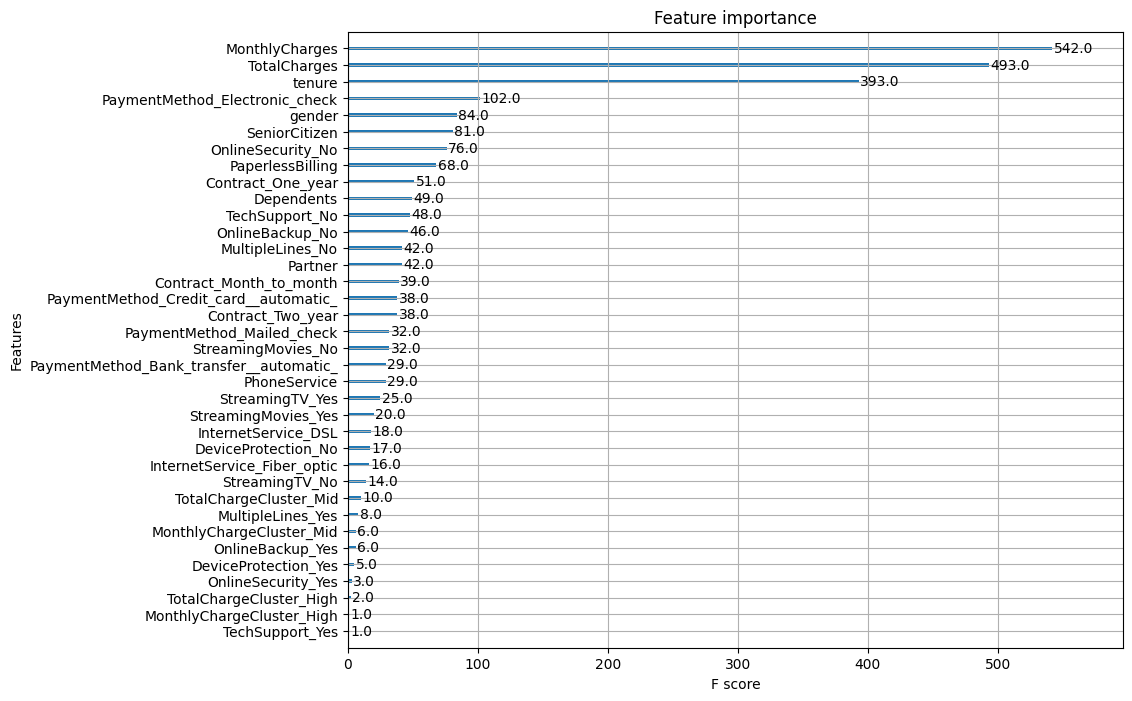

In [56]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

We can see that our model assigned more importance to TotalCharges and MonthlyCharges compared to others.

Finally, the best way to use this model is assigning Churn Probability for each customer, create segments, and build strategies on top of that. To get the churn probability from our model, utilize the code block below:

In [57]:
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]

In [58]:
df_data[['customerID', 'proba']].head()

,customerID,proba
0,7590-VHVEG,0.664355
1,6713-OKOMC,0.107603
2,7469-LKBCI,0.016104
3,8779-QRDMV,0.880785
4,1680-VDCWW,0.059783


In [62]:
# Assuming df_data is your DataFrame and it includes 'customerID' and 'proba' columns
sorted_df = df_data[['customerID', 'proba']].sort_values(by='proba', ascending=False)

sorted_df.head(10)

,customerID,proba
3556,7216-EWTRS,0.955052
4052,5419-JPRRN,0.946465
3604,4910-GMJOT,0.941559
3833,1069-XAIEM,0.936893
3856,9300-AGZNL,0.936860
3673,8149-RSOUN,0.936569
3528,9497-QCMMS,0.936451
3560,7181-BQYBV,0.935159
3696,5178-LMXOP,0.933237
3812,3178-FESZO,0.929854


**FULL CIRCLE**

From here on we can continue by grouping or clustering the most likely customers to churn and come up with strategies to incentivize them, or measure whether it is better for our comapny to cut our losses with them. Essentially, we can measure if losing some customers is ok for us.